<a href="https://colab.research.google.com/github/itsnev1lle/mouse_gaming_recom/blob/main/Sistem_Rekomendasi_Mouse_Gaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **"Sistem Rekomendasi Mouse Gaming Menggunakan Algoritma KNN dan K-Mean"**

In [ ]:
!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_score, recall_score, f1_score, silhouette_score
)
from imblearn.over_sampling import SMOTE

In [ ]:
# ========== 1. LOAD DATASET ==========
file_path = "/content/2025_06_15_MousedB.csv"
df = pd.read_csv(file_path, sep=';')  # ← penting!
print("✅ Dataset loaded:", df.shape)
print(df.head())

# Rename agar kolom lebih konsisten
df.rename(columns={'Weight (g)': 'Weight'}, inplace=True)

✅ Dataset loaded: (1038, 24)
          Brand                       Name  Length (mm)  Width (mm)  \
0  Pulsar ZywOo    The Chosen Mouse - Mini        115.6        63.4   
1  Pulsar ZywOo  The Chosen Mouse - Medium        122.0        66.0   
2       WLmouse                    Sword X        123.0        67.0   
3    Darmoshark               M3 Micro Pro        105.5        54.6   
4          ASUS    ROG Gladius II Wireless        126.0        67.0   

   Height (mm) Weight (g)        Shape   Hump placement           Front flare  \
0         40.7       55.0    Ergonomic           Center    Outward - moderate   
1         43.0       59.0    Ergonomic           Center    Outward - moderate   
2         42.0       47.0    Ergonomic           Center    Outward - moderate   
3         33.5       42.0  Symmetrical  Back - moderate      Outward - slight   
4         45.0       90.0    Ergonomic           Center  Outward - aggressive   

  Side curvature  ... Connectivity             Sensor Sen

In [ ]:
# ========== 2. PREPROCESSING ==========
if 'Name' in df.columns:
    df.drop(columns=['Name'], inplace=True)  # kolom tidak relevan

# Encoding kolom object
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Scaling semua fitur numerik
feature_cols = [col for col in df.columns if col not in ['Cluster', 'Recommended', 'PCA1', 'PCA2']]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[feature_cols]), columns=feature_cols)

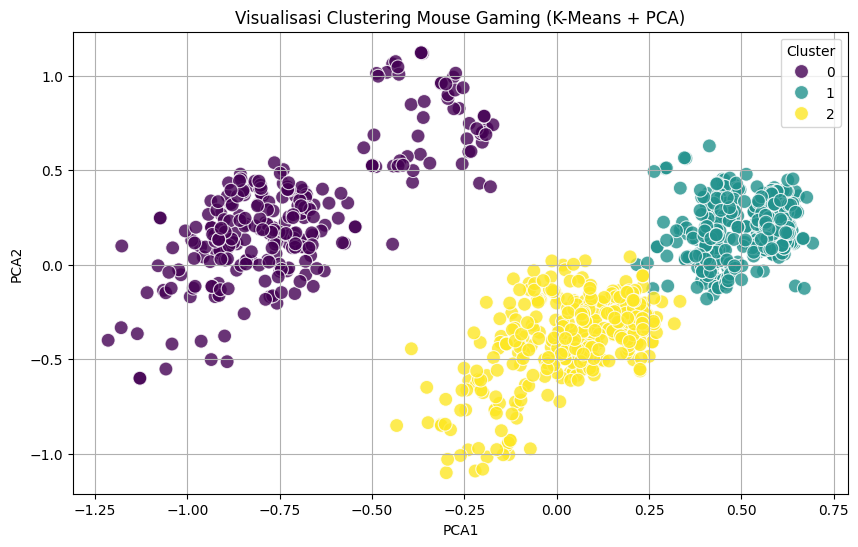

In [ ]:
# ========== 3. K-MEANS ==========
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualisasi dengan PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=100, alpha=0.8)
plt.title("Visualisasi Clustering Mouse Gaming (K-Means + PCA)")
plt.grid(True)
plt.show()

In [ ]:
# ========== 4. SIMULASI REKOMENDASI (Labeling) ==========
# Ubah threshold agar tidak terlalu sempit
dpi_threshold = df['DPI'].median()         # Misalnya: 20
weight_threshold = df['Weight'].quantile(0.25)  # Mouse ringan: kuartil bawah

df['Recommended'] = ((df['DPI'] > dpi_threshold) & (df['Weight'] < weight_threshold)).astype(int)

print("📊 Distribusi Recommended (relatif):")
print(df['Recommended'].value_counts())

📊 Distribusi Recommended (relatif):
Recommended
0    927
1    111
Name: count, dtype: int64


In [ ]:
# ========== 5. KNN DENGAN SMOTE ==========
X = df.drop(columns=['Recommended', 'Cluster', 'PCA1', 'PCA2'])
y = df['Recommended']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\n📈 Distribusi setelah SMOTE:")
print(pd.Series(y_train_res).value_counts())

# KNN Training
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)
y_pred = knn.predict(X_test)


📈 Distribusi setelah SMOTE:
Recommended
0    741
1    741
Name: count, dtype: int64


In [ ]:
# ========== 6. EVALUASI & TABEL PERFORMANCE ==========
# KNN Metrics
precision_0 = precision_score(y_test, y_pred, pos_label=0)
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_0 = f1_score(y_test, y_pred, pos_label=0)
f1_1 = f1_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)

# K-Means Silhouette Score
silhouette = silhouette_score(df_scaled, df['Cluster'])

# Buat Tabel Performance Measure
perf_df = pd.DataFrame({
    'Algoritma': ['KNN (SMOTE)', 'K-Means'],
    'Presisi 0': [f"{precision_0:.2f}", '—'],
    'Presisi 1': [f"{precision_1:.2f}", '—'],
    'Recall 0': [f"{recall_0:.2f}", '—'],
    'Recall 1': [f"{recall_1:.2f}", '—'],
    'F1 Score 0': [f"{f1_0:.2f}", '—'],
    'F1 Score 1': [f"{f1_1:.2f}", '—'],
    'Akurasi': [f"{accuracy:.2f}", '—'],
    'Silhouette Score': ['—', f"{silhouette:.2f}"]
})

print("\n📊 TABEL PERFORMANCE MEASURE:")
print(perf_df.to_string(index=False))



📊 TABEL PERFORMANCE MEASURE:
  Algoritma Presisi 0 Presisi 1 Recall 0 Recall 1 F1 Score 0 F1 Score 1 Akurasi Silhouette Score
KNN (SMOTE)      1.00      0.73     0.96     1.00       0.98       0.85    0.96                —
    K-Means         —         —        —        —          —          —       —             0.16


In [ ]:
# ========== 7. SIMPAN TABEL KE FILE ==========
perf_df.to_csv("/content/performance_measure.csv", index=False)
print("\n✅ File 'performance_measure.csv' berhasil disimpan.")


✅ File 'performance_measure.csv' berhasil disimpan.
